In [114]:
# Importaciones iniciales
import sys
from collections import OrderedDict

from mne import create_info, concatenate_raws, preprocessing
from mne.io import RawArray
from mne.channels import read_montage
from mne.viz import plot_epochs_image

import pandas as pd
import numpy as np
import scipy as sp

from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt

# importar utilidades de muse-lsl
sys.path.append('../muse')
import utils

%matplotlib inline

In [115]:
# variables globales

# en esta lista voy a ir guardando los objetos epochs que serán usados
# como entrada a los clasificadores
clasificables = OrderedDict()
clasificadores = OrderedDict()

## Cargar datos desde muse
Se pueden leer datos del dispositivo y guardarlos en un .csv con la utilidad  `lsl-record.py` y `muse-lsl.py`  

Ejemplo: 

`sudo python muse-lsl.py --address 00:55:DA:B3:4C:6C`

`python stimulus_presentation/videoStim.py -e 3 & python lsl-record.py -d 1200`

lsl-record.py espera un canal de eventos. videoStim.py lo provee enviando dos datos: el inicio del evento y la evaluación que hace del evento del usuario.

## Cargar datos CSV para entrenamiento
muse-lsl tiene una utilidad propia para cargar los datos de un .csv. Para utilizarla primero se deben guardar los datos bajo el directorio "data/<nombre>" e invocar la función utils.load_data(). La misma leerá todos los .csv bajo el directorio pasado como argumento y devolverá un objeto del tipo mne.raw.

In [116]:
# Carga los datos desde una carpeta. Espera archivos CSV
subject = 4
session = 1

raw = utils.load_data('feels', sfreq=256.,
                            subject_nb=subject, session_nb=session,
                            ch_ind=[0, 1, 2, 3])
# filtra señal entre 0,1 y 40 Hz
raw.filter(0.1,40,skip_by_annotation='edge', fir_design='firwin')
raw.info

Creating RawArray with float64 data, n_channels=5, n_times=301200
    Range : 0 ... 301199 =      0.000 ...  1176.559 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=117636
    Range : 0 ... 117635 =      0.000 ...   459.512 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=285588
    Range : 0 ... 285587 =      0.000 ...  1115.574 secs
Ready.
Setting up band-pass filter from 0.1 - 40 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 8449 samples (33.004 sec) selected
Setting up band-pass filter from 0.1 - 40 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 8449 samples (33.004 sec) selected
Setting up band-pass filter from 0.1 - 40 Hz
l_trans_bandwidth chosen to be 0.1 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 8449 samples (33.004 sec) selected


<Info | 18 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | TP9, AF7, AF8, TP10, Stim
    chs : list | 5 items (EEG: 4, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 7 items
    events : list | 0 items
    highpass : float | 0.1 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 40.0 Hz
    meas_date : ndarray | 1970-01-01 00:00:00 GMT
    nchan : int | 5
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 256.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout : No

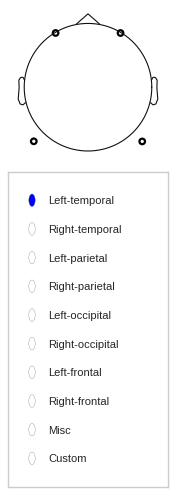

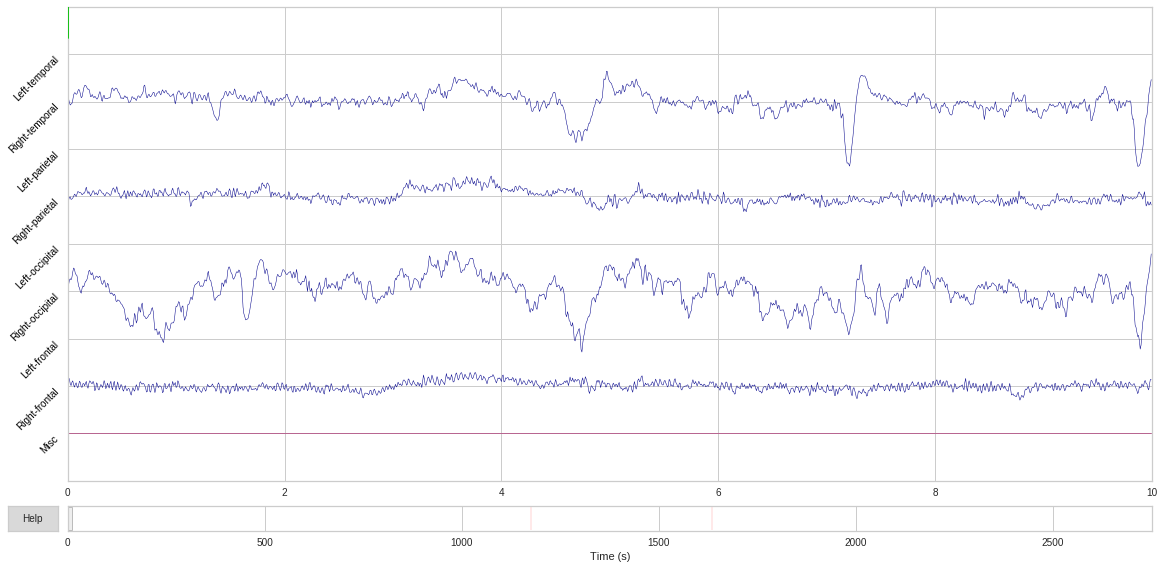

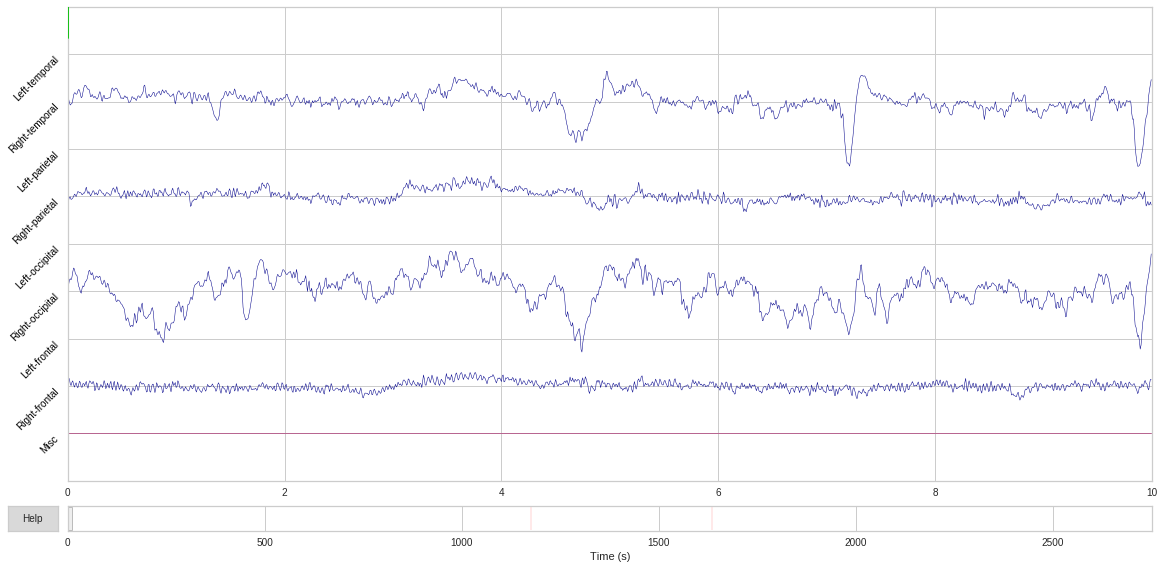

In [117]:
# explorar los datos
%matplotlib inline
raw.plot(butterfly=True, color=dict(eeg='darkblue',  stim='m'),
               show=True, event_color='red', group_by='position', scalings=dict(eeg=20e-6),
               show_options=False)

Effective window size : 8.000 (s)


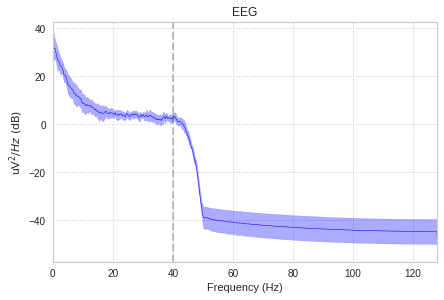

In [118]:
# ver espectro de frecuencia de los EEG
%matplotlib inline
raw.plot_psd(color=(0, 0, 1),
                   show=False, average=True);

Como puede verse, existe un pico en 50Hz y un armónico en 100Hz en los datos crudos. Además, como se verá más adelante,  existe bastante ruido, sobre todo en los canales TP9 y TP10. En las siguientes secciones veremos distintos métodos de filtrado.

## Epoching
Se dividen los registros en Epochs entre -100ms y 800ms luego del evento. No se hace corrección a la baseline y NO se rechazan los eventos mayores a 100uV (mayormente parpadeos) porque es lo que se quiere clasificar.
Para indicar el inicio de un Epoch se toma un evento del canal de estimulos, el evento siguiente es la evaluación que hace el usuario del estímulo.

### Eventos

In [119]:
# descubrir eventos desde el EEG crudo
from mne import Epochs, find_events

# todos los eventos según el canal de estímulos
events = find_events(raw, shortest_event=2, verbose='ERROR')
# obtengo solo las evaluaciones
valuaciones = events[1:len(events):2]
# obtengo solo los marcadores de inicio de evento
events = events[0:len(events):2]

# verifico que los eventos tengan el formato correcto 
for el in events:
    if el[2] > 10:
        raise (RuntimeError, "Lista de eventos incorrecta")

        
# verifico que las valoraciones tengan el formato correcto 
for el in valuaciones:
    if el[2] < 11:
        raise (RuntimeError, "Lista de valuaciones incorrecta")

if(len(events)!= len(valuaciones)):
    raise (RuntimeError, "Longitudes eventos y valuaciones no coinciden")
    
# transformo el feedback en una clase
# {neutro:11, positivo:22, negativo:33}
for i,val in enumerate(valuaciones):
    valList = list(str(val[2])) # separa el valor
    # caso neutro
    if(int(valList[1]) > 5 or int(valList[0]) == 5):
        valuaciones[i][2]=11
    
    else:
        # caso positivo
        if (int(valList[0]) <= 4):
            valuaciones[i][2]=22
        # caso negativo
        if (int(valList[0]) >= 6):
            valuaciones[i][2]=33

# reemplaza la tercer columna de events por la de valuaciones
# my_array[:, 0], my_array[:, 1] = my_array[:, 1], my_array[:, 0].copy()
events[:,2] = valuaciones[:,2]
events[:,2].transpose()

array([11, 22, 11, 11, 11, 11, 11, 33, 22, 11, 11, 22, 11, 11, 22, 22, 22,
       11, 11, 11, 22, 11, 11, 11, 22, 11, 11, 11, 33, 11])

### Epoching

In [120]:
#division de los datos en intervalos discretos

# etiquetas
event_id = {'Neutro': 11, 'Positivo':22, 'Negativo': 33}  # , 'Negativo':3

# Inicio del epoch
tmin = -0.1
# fin del epoch
tmax = 2.9

epochs = Epochs(raw, events=events, event_id=event_id,
                tmin=tmin, tmax=tmax, baseline=None, preload=True,
                verbose='DEBUG', picks=[0, 1, 2, 3])  # , reject={'eeg': 490e-6})
# visualizar epochs promedio sin filtrar
#utils.plot_per_event(epochs, title="Sin filtro")


30 matching events found
0 projection items activated
Loading data for 30 events and 769 original time points ...
0 bad epochs dropped


Resulta evidente si comparamos las gráficas, que hemos eliminado el ruido de alta frecuencia que afectaba a las curvas. Pero no se han eliminado los artefactos correspondientes a señales biológicas.

En la figura superior se han graficado los promedios de los 4 canales para los epochs correspondientes a los eventos de /Parpadeo/ y de /No parpadeo/. En las siguientes secciones se reproducirán las gráficas para poder evaluar la efectividad de las técnicas de filtrado.

In [121]:
#muestra los epochs. La presentación es interactiva y al hacer click sobre el Epoch, se los marca como malos
%matplotlib inline
# block=True significa que la ejecución del programa se bloquea hasta que se cierre la figura
# útil si se quiere marcar canales on the fly.
#epochs.drop([2,3,9]) #subject 3
#epochs.plot(block=True, events=events);


In [122]:
#from autoreject import LocalAutoRejectCV, compute_thresholds
#from functools import partial

#thresh_func = partial(compute_thresholds, method='bayesian_optimization', random_state = 344)
#ar = LocalAutoRejectCV(cv=4, thresh_func=thresh_func)
#epochs_clean = ar.fit_transform(epochs)  
#epochs_clean.plot(block=True, events=events);

In [123]:
# Borro algunos epochs que sé a priori que vienen feos.
# Para lograr consistencia, estos mismos epochs deben
# ser eliminados de futuros epochs
#dropped = [18, 20, 31, 32]
# epochs_train.drop(dropped) # serán eliminados en la fase de clasificación
#clasificables['Epochs autoreject'] = epochs_clean
clasificables['Epochs original'] = epochs

### Evoked
En lugar de trabajar con X1 epochs de estímulos neutros, X2 epochs de estímulos positivos y X3 epochs de estímulos negativos, se conserva sólo 1 epoch de cada clase correspondiente al promedio de los X1, X2 y X3 según corresponda.

In [124]:
evoked_pos = epochs["Positivo"].average()
evoked_neu = epochs["Neutro"].average()
evoked_neg = epochs["Negativo"].average()
#evoked_pos.plot(show=False,window_title="Evoked",spatial_colors=True);

### PCA

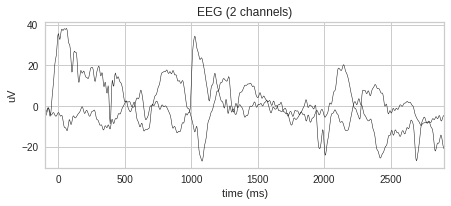

In [125]:
from mne import create_info, EvokedArray
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA

X = epochs.get_data()
pca = UnsupervisedSpatialFilter(PCA(2), average=False)
pca_data = pca.fit_transform(X)
ev = EvokedArray(np.mean(pca_data, axis=0),
                     create_info(2, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)
ev.plot(show=False, window_title="PCA");


## Filtrado - Independent Component Analysis


Aplicaremos ICA a los datos crudos (raw_train) y a los epochs.

In [126]:
# ICA is sensitive to low-frequency drifts and therefore requires the data to be high-pass filtered prior to fitting.
from mne.preprocessing import ICA
from mne import pick_types
# numero de componentes de salida si no
# se indica, no hay reduccion de deminsionalidad
max_pca_components = 4
# numero de componentes para llegar a la varianza
# indicada por n_components
n_components = 0.95

# Aplico ICA a la señal cruda original
ica = ICA(max_pca_components=max_pca_components, method='fastica')
ica_raw = ica.fit(raw)
epochs_ica_raw = Epochs(ica_raw.get_sources(raw), events=events, event_id=event_id,
                      tmin=tmin, tmax=tmax, baseline=None, preload=True,
                      verbose='ERROR', picks=None)
#epochs_ica_raw.drop([2,3,9])


# Aplico ICA a los epochs previamente creados
ica_epochs = ICA(method='fastica',max_pca_components=max_pca_components).fit(epochs)

Fitting ICA to data using 4 channels. 
Please be patient, this may take some time
Using all PCA components: 4
Fitting ICA to data using 4 channels. 
Please be patient, this may take some time
Using all PCA components: 4


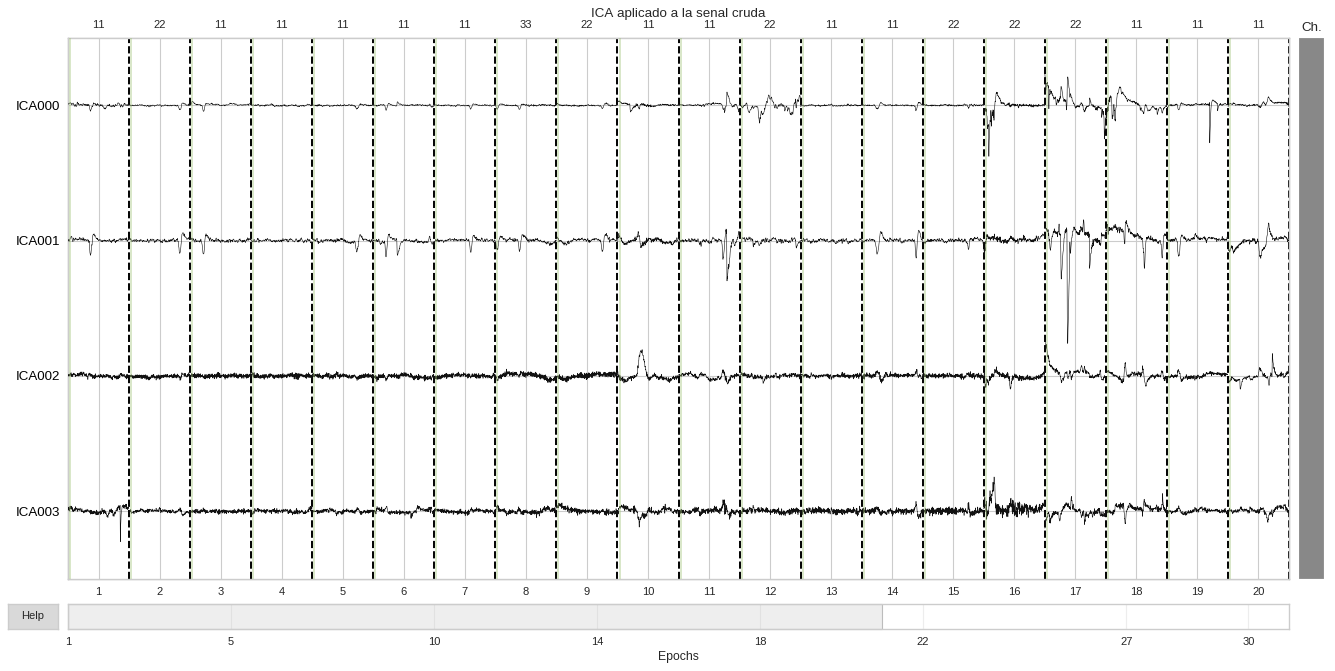

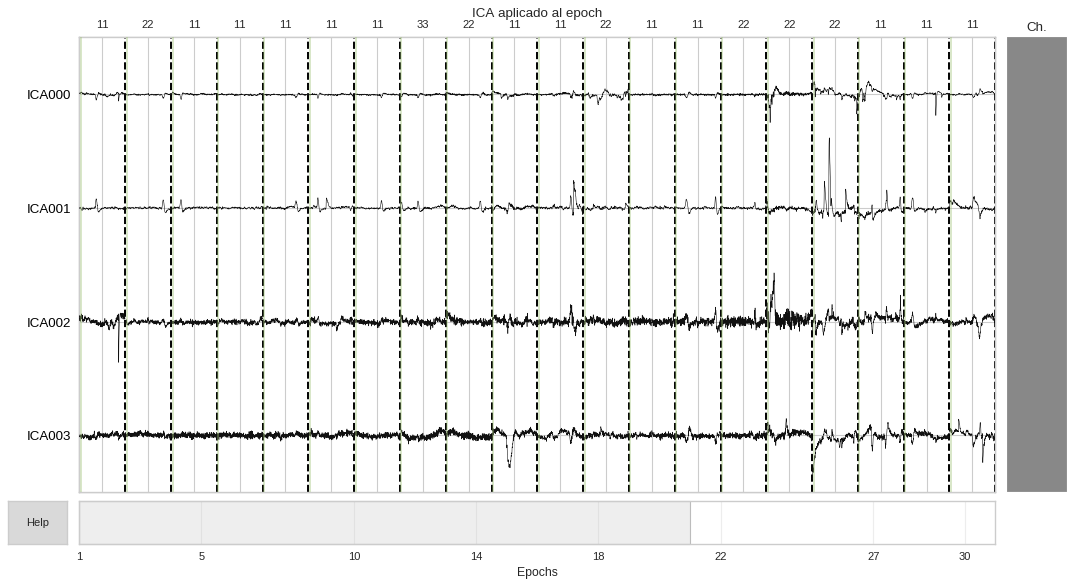

In [127]:
%matplotlib inline
# Plot estimated latent sources given the unmixing matrix.
epochs_ica_raw.plot(show=True, scalings='auto', title='ICA aplicado a la senal cruda', block=True);
#ica_raw.plot_properties(raw, picks=[0,1,2,3])
#ica.plot_sources(raw, title='ICA senial cruda')
ica_epochs.plot_sources(epochs, title='ICA aplicado al epoch');
#ica_epochs.plot_properties(epochs, picks=[0,1,2,3])

Notar que las señales son levemente diferentes, pues son soluciones independientes, aún cuando han sido extraidas de la misma señal original.

Transforming to ICA space (4 components)
Zeroing out 1 ICA components


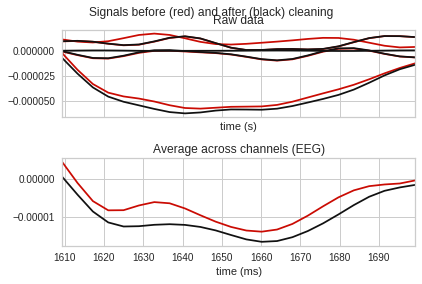

Transforming to ICA space (4 components)
Zeroing out 1 ICA components


In [128]:
# elimino las componentes ICA000 e ICA003 y proyecto nuevamente la señal
# al espacio de sensores.
%matplotlib inline
from mne.viz import plot_ica_overlay
plot_ica_overlay(ica_raw, raw ,exclude = [1], start=412, stop=436);
clean_raw = ica_raw.apply(raw.copy(),exclude=[1])
#clean_raw.plot(show=True, scalings='auto', title='Señal limpia');

In [113]:
%matplotlib auto
epochs_clean = Epochs(clean_raw, events=events, event_id=event_id,
                      tmin=tmin, tmax=tmax, baseline=None, preload=True,
                      verbose='ERROR', picks=[0,1,2,3])
#epochs_clean.drop([2,3,9]) # fede
#epochs_clean.drop([9,10,15,16,17,20,27,29]) # gabi

epochs_clean.plot(block=True, events=events);


Using matplotlib backend: TkAgg
Channels marked as bad: []


In [12]:
# Agrego los objetos obtenidos a la lista de clasificables
# clasificables['ICA senial cruda']= epochs_ica_raw
clasificables['ICA epochs'] = epochs_clean

# Extracción de  características
En esta sección se trabajará con el objeto clasificacables, y se creará en base a este el vector de entrada al clasificador. 
Elementos del vector
* Señal original:Promedio, desviación estandar, máximo y mínimo
* ICA, PCA: Promedio, desviación estandar, máximo y mínimo
* Espectro de potencia: Promedio, desviación estandar, máximo y mínimo

TODO 
* normalized log power in 6 different frequency band (0.1 - 4 ; 4- 8 ; 8 - 15 ; 15 - 30 ; 30 - 90 ; 90 - 170 Hz) and for each channel. Power spectral density was estimated using Welch's method (window of 512 sample, 25% overlap). PSD was averaged in each band, normalized by the total power before applying a logarithm. Total size of this dataset is 6 x 16 = 96 features.
* various measures including signal statistics (mean, min, max, variance, 90th and 10th percentiles), AR error coefficient (order 5), Petrosian and Higuchi fractal dimension and Hurst exponent
* cross-frequency coherence (in the same 6 sub-band as in the relative log power features) of each channels, i.e. the estimation of coherence is achieved between pairs of frequency of the same channel instead to be between pairs of channels for each frequency band. This produce set of 6x6 coherence matrices, that are then projected in their tangent space and vectorized. T

In [129]:
# tengo que mover esto a otro lugar

from scipy.signal import hanning, welch

# funcion que devuelve la potencia espectral normalizada en 4 bandas de 
# frecuencia para cada canal
def relative_log_power(data, window=256, fs=256, overlap=0.25,
                       frequencies = [[0.1, 4], [4, 8], [8, 15], [15, 30]]):
    noverlap = int(window * overlap)
    freqs, power = welch(data, fs=fs, nperseg=window, noverlap=noverlap)

    out = []
    if frequencies is None:
        out = power
    else:
        for fr in frequencies:
            tmp = (freqs >= fr[0]) & (freqs < fr[1])
            a = tmp
            b = power
            out.append((power[tmp].mean()))
    return np.log(np.array(out) / np.sum(out, 0))


# obtengo la potencia logartímica en un array
# de la forma (bandas, canales) = (4x4)
    
#potencia_log = relative_log_power(evoked_pos.data)

# toma un epoch en forma de ndarray [n_muestras] y
# calcula una serie de estadísticas para el canal al que 
# pertenecen las muestras
def BasicStats(data):
    m = np.mean(data)
    sd = np.std(data)
    ku = sp.stats.kurtosis(data)
    sk = sp.stats.skew(data)
    p90 = np.percentile(data, 90)
    p10 = np.percentile(data, 10)
    return np.asarray([m, sd, ku, sk, p90, p10])


def cumulative_log_power(data, window=256, fs=256, overlap=0., indexes=[4, 8, 15, 25, 30, 40]):
    noverlap = int(window * overlap)
    freqs, power = welch(data, fs=fs, nperseg=window, noverlap=noverlap)
    power = power[np.array(indexes)]
    out = np.cumsum((power), 0)
    out = out / np.max(out)
    out = out[:-1]
    return out 

def spectral_edge_frequency(data, window=256, fs=256, overlap=0., edges=[0.5, 0.7, 0.8, 0.9, 0.95]):
    noverlap = int(window * overlap)
    freqs, power = welch(data, fs=fs, nperseg=window, noverlap=noverlap)
    out = np.cumsum((power), 0)
    out = out / np.max(out)
    ret = []
    if np.sum(np.isnan(out))>0:
        ret = np.ones((len(edges), 16)) * np.nan
    else:
        for edge in edges:
            tmp = []
            tmp.append(freqs[np.where(out>edge)[0][0]])
            ret.append(tmp)
        ret = np.array(ret)
    return ret



In [130]:
# para cada epoch construyo un array vacío
# con dimensión (número de epochs, canales, características)
n_canales = 4
n_caracteristicas = 15

def ObtenerCaracteristicas(_ep):
    vector = np.zeros((n_canales, n_caracteristicas))

    for j in range(n_canales):
        # genera características para cada canal
        espectro = relative_log_power(_ep[j])
        estadisticas = BasicStats(_ep[j])
        cum_power = cumulative_log_power(_ep[j])
        misc = spectral_edge_frequency(_ep[j])
        out = np.concatenate((espectro, estadisticas, cum_power))
        # coloca las características en el vector de entrada
        n_elementos = len(out)
        mask = np.concatenate((np.ones(n_elementos), np.zeros(n_caracteristicas - n_elementos)))
        np.place(vector[j], mask, out)
    return vector

def ObtenerVector(_epochs):

    vector = np.zeros((len(_epochs), n_canales, n_caracteristicas))
    for i, ep in enumerate(_epochs):
        for j in range(n_canales):
            # genera características para cada canal
            espectro = relative_log_power(ep[j])
            estadisticas = BasicStats(ep[j])
            cum_power = cumulative_log_power(ep[j])
            misc = spectral_edge_frequency(ep[j])
            out = np.concatenate((espectro, estadisticas, cum_power))
            # coloca las características en el vector de entrada
            n_elementos = len(out)
            mask = np.concatenate((np.ones(n_elementos), np.zeros(n_caracteristicas - n_elementos)))
            np.place(vector[i][j], mask, out)
            
    return vector

#  Clasificación

En el contexto de EEG, al aprendizaje supervisado se le llama _decoding_ o también _multivariate pattern analysis (MPVA)_ 


In [131]:
#imports
from mne import io, EvokedArray
from mne.decoding import Vectorizer, get_coef, LinearModel

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import tree

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM
from pyriemann.spatialfilters import Xdawn
from pyriemann.utils.viz import plot_confusion_matrix


In [133]:
# clasificadores

clasificadores = OrderedDict()

clasificadores['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clasificadores['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
#clasificadores['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clasificadores['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clasificadores['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clasificadores['Decision Tree'] = make_pipeline(
    Vectorizer(), StandardScaler(), tree.DecisionTreeClassifier())
clasificadores['Cov+LR'] = make_pipeline(Covariances(estimator='lwf'), TangentSpace(),
                    LogisticRegression())

Usando a 'Potencia' como vector de entrada al clasificador
>>> Usando como clasificador a 'Vect + LR'
>>> Usando como clasificador a 'Vect + RegLDA'
>>> Usando como clasificador a 'ERPCov + TS'
>>> Usando como clasificador a 'ERPCov + MDM'
>>> Usando como clasificador a 'Decision Tree'
>>> Usando como clasificador a 'Cov+LR'


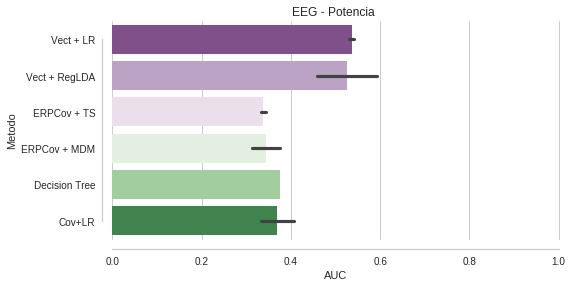

In [135]:
from sklearn.cross_validation import StratifiedKFold, cross_val_score

# bucle de entrenamiento y validación de los 
# clasificadores 
clasificables.clear()
vector_entrada = ObtenerVector(epochs_clean)
#vector_entrada = epochs_clean.get_data()
clasificables["Potencia"] = vector_entrada

for cla in clasificables:
    un_epoch = clasificables[cla]
    if isinstance(un_epoch, np.ndarray):
        
        print("Usando a %r como vector de entrada al clasificador" % cla)
        
        
        # format data

        X = vector_entrada* 1e6
        y = epochs_clean.events[:, -1]
        
        # define cross validation 
        #cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=21)
        cv = StratifiedKFold(y, n_folds=2, shuffle=True, random_state=43)

        # run cross validation for each pipeline
        auc = []
        methods = []
        for m in clasificadores:
            print(">>> Usando como clasificador a %r" % m)
            res = cross_val_score(clasificadores[m], X, y==22, scoring='roc_auc', cv=cv, n_jobs=-1)
            auc.extend(res)
            methods.extend([m]*len(res))

        results = pd.DataFrame(data=auc, columns=['AUC'])
        results['Metodo'] = methods

        plt.figure(figsize=[8,4])
        sns.barplot(data=results, x='AUC', y='Metodo', palette="PRGn").set_title('EEG - %s ' % cla)
        plt.xlim(0.0, 1.0)
        sns.despine(offset=10, trim=True)        
        
        
    else:
        print('%r no es un Epoch' % cla)

    
 

### Autoreject
Existe una utilidad, llamada autoreject que automáticamente elimina datos con ruidos e incluso tratar de arreglar algunos otros: https://autoreject.github.io/

In [141]:
vector_entrada = ObtenerVector(epochs_clean)
X = vector_entrada
y = epochs_clean.events[:, -1]

for model in clasificadores:
    clf = clasificadores[model]
  
    clf.fit(X, y)
    joblib.dump(clf, str(model)+".pkl") 



(array([11, 22, 11, 11, 33, 22, 22, 11, 11, 11, 22, 11]), 'Vect + LR')


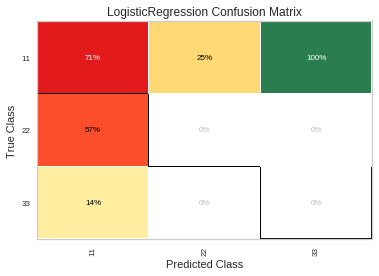

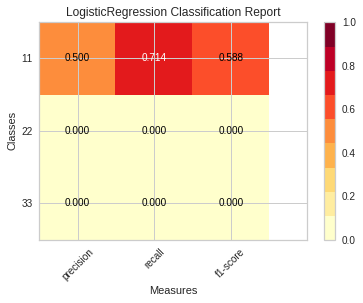

(array([11, 11, 11, 22, 11, 11, 22, 22, 11, 11, 33]), 'Vect + LR')


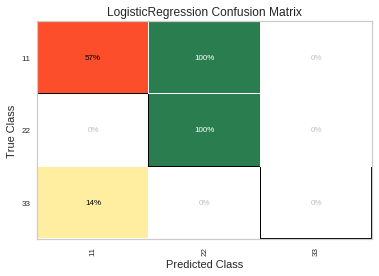

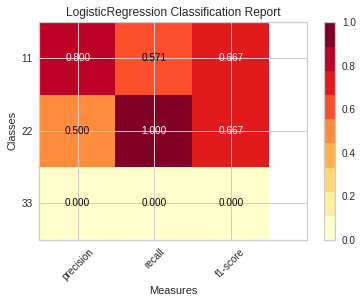

(array([11, 22, 11, 11, 33, 22, 22, 11, 11, 11, 22, 11]), 'Vect + RegLDA')


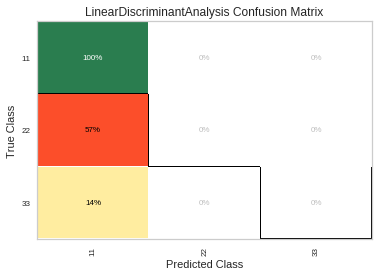

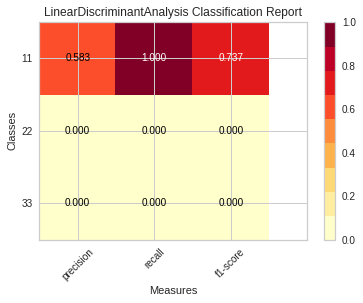

(array([11, 11, 11, 22, 11, 11, 22, 22, 11, 11, 33]), 'Vect + RegLDA')


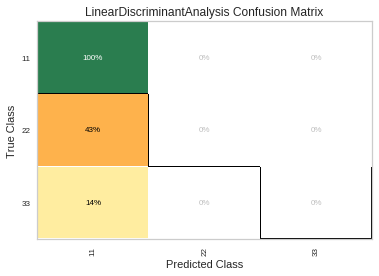

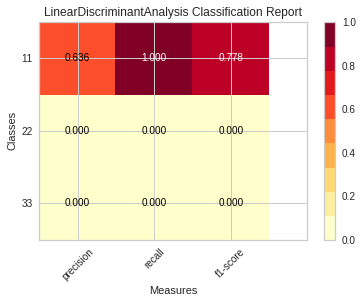

(array([11, 22, 11, 11, 33, 22, 22, 11, 11, 11, 22, 11]), 'ERPCov + TS')


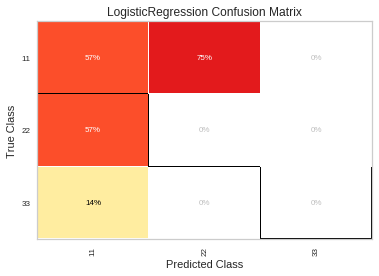

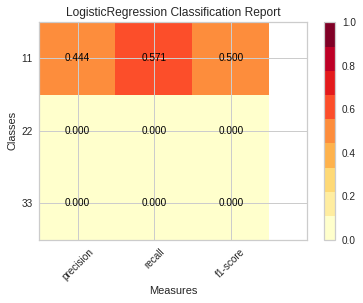

(array([11, 11, 11, 22, 11, 11, 22, 22, 11, 11, 33]), 'ERPCov + TS')


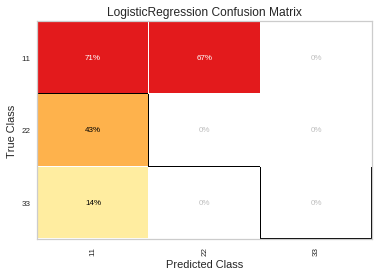

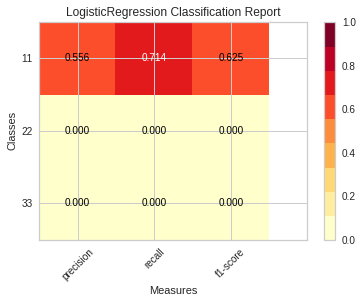

(array([11, 22, 11, 11, 33, 22, 22, 11, 11, 11, 22, 11]), 'ERPCov + MDM')


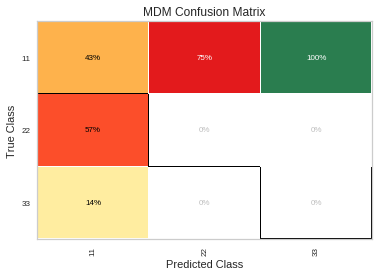

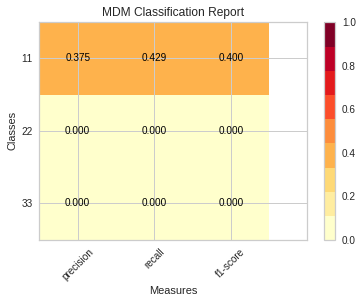

(array([11, 11, 11, 22, 11, 11, 22, 22, 11, 11, 33]), 'ERPCov + MDM')


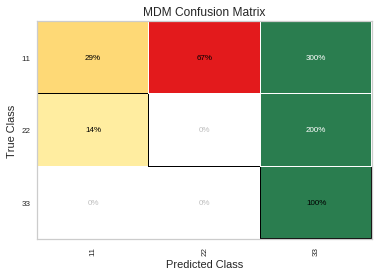

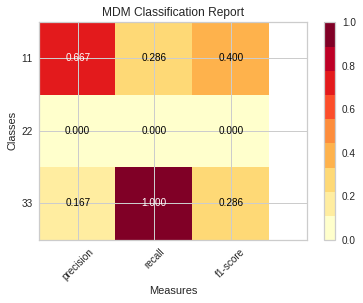

(array([11, 22, 11, 11, 33, 22, 22, 11, 11, 11, 22, 11]), 'Decision Tree')


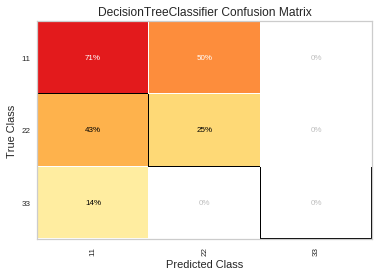

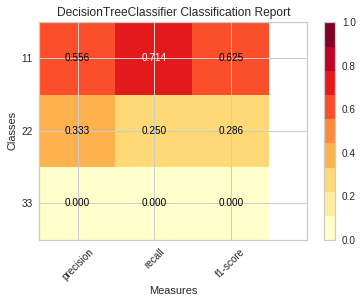

(array([11, 11, 11, 22, 11, 11, 22, 22, 11, 11, 33]), 'Decision Tree')


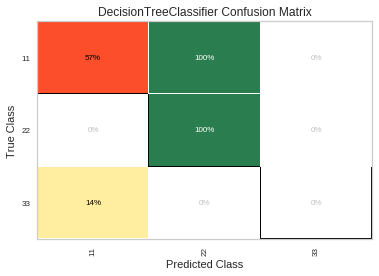

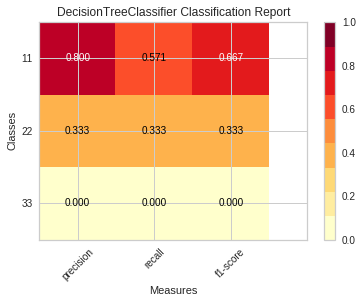

(array([11, 22, 11, 11, 33, 22, 22, 11, 11, 11, 22, 11]), 'Cov+LR')


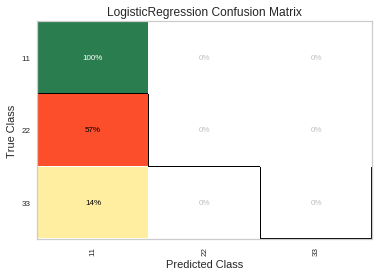

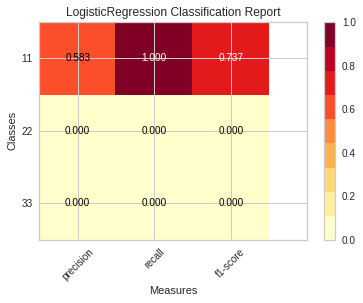

(array([11, 11, 11, 22, 11, 11, 22, 22, 11, 11, 33]), 'Cov+LR')


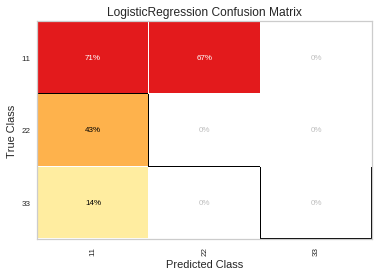

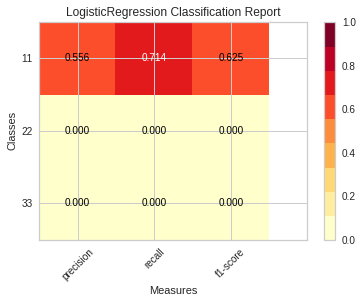

In [136]:
#names = ['Neutro', 'Positivo', 'Negativo']
names = [11,22,33]
#First do our imports
import yellowbrick
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport

y = epochs_clean.events[:, 2]
cv = StratifiedKFold(y, n_folds=2, shuffle=True, random_state=42)


#epochs_data = epochs.get_data() #vector_entrada#
epochs_data = vector_entrada
preds = np.zeros(len(labels))
for model in clasificadores:
    for train_idx, test_idx in cv:
        y_train, y_test = labels[train_idx], labels[test_idx]
        print(y_test, model)
        clf = clasificadores[model]
        X_train = epochs_data[train_idx]
        X_test = epochs_data[test_idx]
        if model != 'Xdawn + RegLDA':

            clf.fit(epochs_data[train_idx], y_train)
        preds[test_idx] = clf.predict(epochs_data[test_idx])

        #The ConfusionMatrix visualizer taxes a model
        cm = ConfusionMatrix(clasificadores[model], classes=names)

        #Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
        if model != 'Xdawn + RegLDA':
            cm.fit(X_train, y_train)


        #To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
        #and then creates the confusion_matrix from scikit learn.
        cm.score(X_test, y_test)

        #How did we do?
        cm.poof()
        
        visualizer = ClassificationReport(clasificadores[model], classes=names)

        visualizer.fit(X_train, y_train)
        visualizer.score(X_test, y_test)
        visualizer.poof()

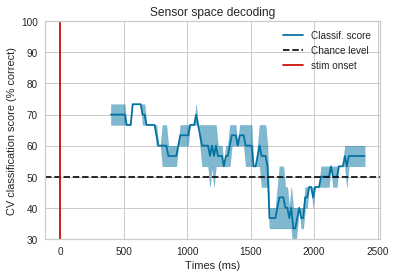

In [96]:
##############################################################################
from pyriemann.estimation import Covariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
 
from sklearn.cross_validation import StratifiedKFold, cross_val_score
cv = StratifiedKFold(y, 2)

X = epochs_clean.get_data() #vector_entrada
#X = vector_entrada
y = epochs_clean.events[:,-1]

window = 256  # time sample
scores = np.zeros((X.shape[0], X.shape[2]))
times = range(window/2, X.shape[2] - window/2,4)
clf = make_pipeline(Covariances(estimator='lwf'), TangentSpace(),
                    LogisticRegression())

scores = np.empty(len(times))
std_scores = np.empty(len(times))
y = epochs_clean.events[:,-1]
for i,t in enumerate(times):
    Xt = X[:, :, (t - window / 2):(t + window / 2)]
    # Run cross-validation
    # Note : for sklearn the Xt matrix should be 2d (n_samples x n_features)
    scores_t = cross_val_score(clf, Xt, y, cv=cv, n_jobs=2)
    scores[i] = scores_t.mean()
    std_scores[i] = scores_t.std()
    #print scores[i]

times = 1e3 * epochs_clean.times[times]
scores *= 100  # make it percentage
std_scores *= 100
plt.plot(times, scores, label="Classif. score")
plt.axhline(50, color='k', linestyle='--', label="Chance level")
plt.axvline(0, color='r', label='stim onset')
plt.legend()
hyp_limits = (scores - std_scores, scores + std_scores)
plt.fill_between(times, hyp_limits[0], y2=hyp_limits[1], color='b', alpha=0.5)
plt.xlabel('Times (ms)')
plt.ylabel('CV classification score (% correct)')
plt.ylim([30, 100])
plt.title('Sensor space decoding')
plt.show()

## Regresión logística

En primer instancia se deben escalar los datos. Al aplicar el scaler, el dataset queda con media cero y desviación estandar unitaria. Esto es necesario porque muchos métodos de ML asumen que así se presentarán los datos.

Luego see dividen los datos en dos sets, de entrenamiento y de pruebas. Con el segundo se verificarán los resultados del primero.

El clasificador usado en esta primera instancia es uno basado en regresión logística, como tal es uno de lo más básicos.


In [297]:
from sklearn.cross_validation import KFold
clf = make_pipeline(XdawnCovariances(2), TangentSpace(
    metric='riemann'), LogisticRegression())

#cv = KFold(len(labels), 10, shuffle=True, random_state=122)
cv = StratifiedKFold(y, 3)


#epochs_data = epochs.get_data() #vector_entrada#
epochs_data = vector_entrada
preds = np.zeros(len(labels))

for train_idx, test_idx in cv:
    y_train, y_test = labels[train_idx], labels[test_idx]
    print(y_test)
    clf.fit(epochs_data[train_idx], y_train)
    preds[test_idx] = clf.predict(epochs_data[test_idx])

# Printing the results
acc = np.mean(preds == labels)
print("Classification accuracy: %f " % (acc))

names = ['Neutro', 'Positivo', 'Negativo']
plot_confusion_matrix(preds, labels, names)
plt.show()

[11 22 11 11 11 33 22 11 22 11]


/home/default/.conda/envs/py27/lib/python2.7/site-packages/pyriemann/utils/base.py:23: RuntimeWarning: invalid value encountered in sqrt
  D = numpy.diag(numpy.sqrt(D))
/home/default/.conda/envs/py27/lib/python2.7/site-packages/pyriemann/utils/base.py:80: RuntimeWarning: invalid value encountered in sqrt
  D = numpy.diag(1.0 / numpy.sqrt(D))


ValueError: array must not contain infs or NaNs

Algunos datos de interés que se muestran: 
1. Los clasificadores basados en matrices de covarianzas arrojan las mejores métricas de clasificación
2. Las mejores features para la clasificación parecen ser las provenientes de la señal original y el del ICA aplicado a la señal original dividida en epochs

## Selección de características

Feature ranking:
1. feature 54 (0.048942)
2. feature 34 (0.033484)
3. feature 49 (0.031723)
4. feature 16 (0.027338)
5. feature 7 (0.025880)
6. feature 29 (0.023504)
7. feature 46 (0.023432)
8. feature 20 (0.023358)
9. feature 48 (0.022785)
10. feature 11 (0.022401)
11. feature 10 (0.022376)
12. feature 59 (0.022340)
13. feature 27 (0.021194)
14. feature 26 (0.020526)
15. feature 22 (0.020424)
16. feature 13 (0.019916)
17. feature 17 (0.019751)
18. feature 47 (0.019584)
19. feature 53 (0.019190)
20. feature 24 (0.018760)
21. feature 31 (0.018574)
22. feature 12 (0.018051)
23. feature 32 (0.016974)
24. feature 23 (0.016394)
25. feature 39 (0.016232)
26. feature 52 (0.016073)
27. feature 14 (0.016019)
28. feature 9 (0.014985)
29. feature 56 (0.014939)
30. feature 58 (0.014592)
31. feature 4 (0.014564)
32. feature 1 (0.014294)
33. feature 55 (0.014094)
34. feature 5 (0.013819)
35. feature 3 (0.013568)
36. feature 38 (0.013525)
37. feature 50 (0.013479)
38. feature 57 (0.013306)
39. featur

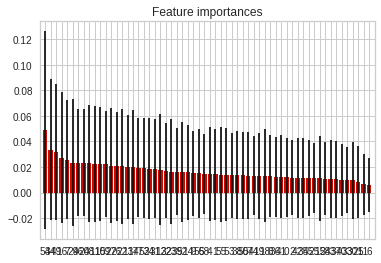

In [94]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
 #                          n_redundant=2, n_repeated=0, n_classes=8,
  #                         n_clusters_per_class=1, random_state=0)

X = vector_entrada
X = X.reshape((X.shape[0],X.shape[1]*X.shape[2]))
y = epochs_clean.events[:, 2]


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


# Extracción de características

En esta sección voy a obtener características complementarias al Epoch (ventana de tiempo compuesta por cuatro canales), para ingresar como vector de entrada al clasificador.

## Potencia espectral


Esta es la potencia de los datos crudos. Como tal no sirve de mucho.

Los valores de exactitud alcanzados no difieren mucho de los obtenidos con un vector de entrada representado por el valor delos elementos en el dominio del tiempo. Hay que ver si esta afirmación se mantiene para otro tipo de problemas

# TODO
- TODO mne.set_eeg_reference (incluir referencia para mejorar SNR?)
- TODO Aplicar filtros como CSP, aunque lo dejaría para el final, así comparo cómo funciona con y sin filtros.
- ~~TODO ICA Preprocessing for artifact supression.~~
- TODO Epoching on the fly
- TODO http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
- TODO Usar https://github.com/autoreject/autoreject para rechazar malos experimentos.